# **Lab-10-4-1 Image Folder**

PyTorch에서는 **ImageFolder**라는 라이브러리를 제공한다. 이는 다음과 같은 <u>계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용</u>할 수 있다. 

다시 말해 다음과 같이 각 이미지들이 자신의 레이블(Label) 이름으로 된 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용하여 이를 바로 불러와 객체로 만들면 된다.

	dataset/
           0/
		          0.jpg
	          	1.jpg
              ...
           1/
              0.jpg
              1.jpg
              ...
           ...
           9/
              0.jpg
              1.jpg
              ...
## Practice 	
1. 기존에 존재하는 CIFAR-10 데이터셋을 불러온다.
2. 이를 계층적인 폴더 구조가 되도록 이미지를 저장한다.
3. 그 다음에 다시 ImageFolder 라이브러리로 동일한 CIFAR-10 데이터셋을 불러온다.



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


CIFAR-10의 경우 10개의 레이블로 구성된 데이터셋이므로, 각 레이블의 이미지가 몇 번 등장했는지를 기록해주는 변수를 선언한다.

In [0]:
# os 모듈
# 파일을 복사하거나 디렉터리를 생성하고 특정 디렉터리 내의 파일 목록을 구하고자 할 때 사용
import os 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10
number_per_class = {}

for i in range(num_classes):
  number_per_class[i]=0

이후에 **이미지 Torch 객체**와 **레이블 정수 값**이 들어왔을 때, 이를 실제 폴더에 저장해주는 함수를 작성한다.

In [0]:
def custom_imsave(img, label):
  path = 'dataset/' + str(label) + '/'
  if not os.path.exists(path): # 경로가 없으면 만든다
    os.makedirs(path)

  img = img.numpy()
  img = np.transpose(img, (1, 2, 0))
  image.imsave(path + str(number_per_class[label])+ '.jpg', img)
  number_per_class[label] += 1

  이제 만들어진 도구들을 이용하여 CIFAR-10 데이터셋에서 데이터를 배치 단위로 읽으며, 배치에 포함된 각 이미지를 하나씩 정확한 폴더에 저장될 수 있도록 한다.

In [0]:
def process():
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    for i in range(inputs. size(0)):
      custom_imsave(inputs[i], targets[i].item())

process()

이후에 한 번 0번 레이블(비행기)의 첫 번째 이미지를 출력하도록 해보자. 정상적으로 잘 출력된다.

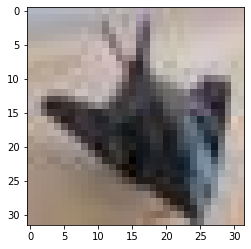

In [8]:
from PIL import Image
from matplotlib.pyplot import imshow

# 0번 레이블의 첫번째 이미지를 출력해본다
# 0번 레이블은 모두 비행기이다
img = Image.open('dataset/0/0.jpg')
imshow(np.asarray(img))

이제 **ImageFolder** 라이브러리를 이용해서, 우리가 <u>저장한 이미지들을 이용해 다시 PyTorch 데이터셋 객체로 불러올 수 있는지 확인</u>해보도록 하자.

In [0]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root='./dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

이미지 출력용 함수는 다음과 같다. PyTorch의 경우 **[Batch Size, Channel, Width, Height]**의 구조를 가지고 있어서, 이를 matplotlib로 출력하기 위해서는 **[Width, Height, Channel]**의 순서로 변경해주어야 한다.

In [0]:
def custom_imshow(img):
  img = img.numpy()
  # 만약 배열 b의 shape(2, 3, 4) => shape (4, 3, 2)로 바꾸고싶다면
  # np.transpose(b, (2, 1, 0))
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.show()

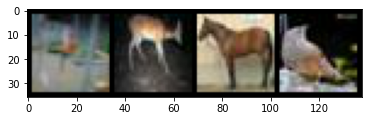

 bird  deer horse  bird


In [14]:
def process(x):
  # 학습용 이미지를 무작위로 가져오기
  dataiter = iter(x)
  images, labels = dataiter.next()
  # 이미지 보여주기
  custom_imshow(torchvision.utils.make_grid(images))
  print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

process(train_loader)


# **Lab-10-4-2 ImageFolder(2)**

앞서 저장한 CIFAR10 이미지를 CNN으로 학습시켜보고자 한다.

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 6, 5), # in_channel , out_channel, filter_size, stride와 padding은 default 1과 0
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, 5), # 위의 out_channel값이 여기서 in_channel
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer3 = nn.Sequential(
        # fully connected 2번진행
        nn.Linear(16*5*5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.Linear(84, 10)
    )

  def forward(self, x):
    out = self.layer1(x)
    # 테스트할때 그때그때 출력하고나서 지울것!
    #print(out.shape) 
    out = self.layer2(out)
    #print(out.shape)
    out = out.view(out.shape[0], -1)
    #print(out.shape)
    out = self.layer3(out)
    return out

In [0]:
# testing (각 layer를 통과하면 어떤 크기가 되는지 확인)
net = CNN().to(device)
test_input = (torch.Tensor(128, 3, 32, 32)).to(device)
test_out = net(test_input)

In [0]:
optimizer = optim.Adam(net.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().to(device)

In [19]:
for epoch in range(5):
  running_loss = 0.0
  for i, data in enumerate(train_loader):
    # [imgs, labels]의 목록인 data로부터 입력을 받은 후;
    imgs, labels = data
    
    # 변화도(Gradient) 매개변수를 0으로 만들고
    optimizer.zero_grad()

    # 순전파 + 역전파 + 최적화를 한 후
    out = net(imgs)
    loss = loss_func(out, labels)
    loss.backward()
    optimizer.step()

    # 통계를 출력합니다.
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Learning Finished!')

[1,  2000] loss: 2.174
[1,  4000] loss: 2.027
[1,  6000] loss: 1.977
[1,  8000] loss: 1.928
[1, 10000] loss: 1.877
[1, 12000] loss: 1.808
[2,  2000] loss: 1.765
[2,  4000] loss: 1.739
[2,  6000] loss: 1.721
[2,  8000] loss: 1.708
[2, 10000] loss: 1.667
[2, 12000] loss: 1.669
[3,  2000] loss: 1.640
[3,  4000] loss: 1.644
[3,  6000] loss: 1.615
[3,  8000] loss: 1.606
[3, 10000] loss: 1.599
[3, 12000] loss: 1.561
[4,  2000] loss: 1.566
[4,  4000] loss: 1.560
[4,  6000] loss: 1.524
[4,  8000] loss: 1.545
[4, 10000] loss: 1.525
[4, 12000] loss: 1.505
[5,  2000] loss: 1.486
[5,  4000] loss: 1.485
[5,  6000] loss: 1.478
[5,  8000] loss: 1.470
[5, 10000] loss: 1.470
[5, 12000] loss: 1.446
Learning Finished!


In [0]:
# 학습한 모델 저장 (불필요한 학습을 줄이기 위해 사용)
torch.save(net.state_dict(), "./cifar_net.pth")

In [21]:
new_net = CNN().to(device)
new_net.load_state_dict(torch.load('./cifar_net.pth'))

<All keys matched successfully>

## Test data로 신경망 검사하기

지금까지 train data로 3회 반복하며 신경망을 학습시켰다. 신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인한다. 만약 예측이 맞다면 샘플을 ‘맞은 예측값(correct predictions)’ 목록에 넣는다.

### 시험용 데이터 확인


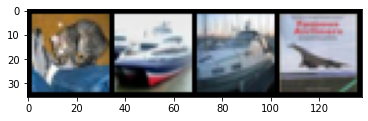

  cat  ship  ship plane


In [40]:
process(test_loader)

이제 이 예제들을 신경망이 어떻게 예측했는지를 본다. 출력은 10개 분류 각각에 대한 값으로 나타난다. 어떤 분류에 대해서 더 높은 값이 나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것이다. 따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아본다.

In [0]:
outputs = new_net(imgs)

In [42]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  deer   car horse


### 전체 데이터셋 확인

In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보인다. 신경망이 뭔가 배우긴 했다는 것이다.

여기서 더 나아가 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아본다.

In [36]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 57 %
Accuracy of  bird : 20 %
Accuracy of   cat : 31 %
Accuracy of  deer : 38 %
Accuracy of   dog : 46 %
Accuracy of  frog : 64 %
Accuracy of horse : 56 %
Accuracy of  ship : 62 %
Accuracy of truck : 61 %


## **Reference**

https://ndb796.tistory.com/373?category=1011147

https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html